In [2]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML
import pandas as pd
import json
import geopandas as gpd
from io import StringIO
from csv import reader
from functools import reduce
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point
from patsy import dmatrices
import warnings
warnings.filterwarnings('ignore')

Question 1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.

In [3]:
# Create paramters
crime_params = {
    'offense_description': 'BURGLARY- AGGRAVATED',
    '$where': 'incident_reported between \'2021-01-01T00:00:00.000\' and \'2021-07-01T00:00:00.000\'',
    '$limit': 2000   

}

# Generate response
response = requests.get('https://data.nashville.gov/resource/2u6v-ujjs.geojson', params = crime_params)

# Convert json object to geopandas DataFrame, drop duplicates
crime = (
    gpd.read_file(StringIO(response.text))
    .drop_duplicates(subset = 'incident_number')
)

Question 2. Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.

In [4]:
# Read in census tract shapefile
tract = (gpd.read_file('data/tl_2019_47_tract.shp'))

# Clean up shapefile, covert to proper geometry
tract = tract[tract['COUNTYFP'] == '037']
tract = tract.rename(columns = {'TRACTCE': 'tract'})
tract = tract.to_crs('EPSG:4326')

# Spatial join burglaries and census tract tables, keep relevant columns
crimeBYtract = gpd.sjoin(crime, tract, how='right', op ='within')
crimeBYtract = crimeBYtract[['incident_number', 'incident_reported', 'geometry', 'tract']]
crimeBYtract['tract'] = crimeBYtract['tract'].astype(str)

# Tract with highest number of burglaries
print(crimeBYtract.groupby('tract')['incident_number'].nunique().nlargest(1))

tract
016300    53
Name: incident_number, dtype: int64


Question 3. For this part, you'll need to request a census API key. Using the 2019 American Community Survey API, obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.

In [5]:
# Load API key for American Community Survey API

with open ('data/census.json') as fi:
    credentials = json.load(fi)
    
api_key = credentials['api_key']

In [6]:
# Create endpoint, parameters, and generate response for population data

pop_params = {
    'get': 'B01001_001E',
    'for': 'tract:*',
    'in': 'state:47 county:037',
    'key': api_key
}

pop_response = requests.get('https://api.census.gov/data/2019/acs/acs5', params = pop_params)

# Convert response to pandas DataFrame and clean up

pop = pop_response.json()
pop = pd.DataFrame(data = pop[1:], columns = pop[0])
pop['B01001_001E'] = pop['B01001_001E'].astype(int)
pop = pop.rename(columns = {'B01001_001E': 'population'})

In [7]:
# Create parameters and generate response for income data

inc_params = {
    'get': 'S1901_C01_012E',
    'for': 'tract:*',
    'in': 'state:47 county:037',
    'key': api_key
}

inc_response = requests.get('https://api.census.gov/data/2019/acs/acs5/subject', params = inc_params)

# Convert response to pandas DataFrame and clean up

inc = inc_response.json()
inc = pd.DataFrame(data = inc[1:], columns = inc[0])
inc = inc.rename(columns={'S1901_C01_012E': 'median_income'})
inc['median_income'] = inc['median_income'].astype(int)

In [50]:
# Merge all into one DataFrame and clean up

df_merge = [crimeBYtract, pop, inc]
crime_pop_inc = reduce(lambda left, right: pd.merge(left, right, on ='tract'), df_merge)
crime_pop_inc.geometry.to_crs('EPSG:4326')
crime_pop_inc = crime_pop_inc[['incident_number', 'incident_reported', 'tract', 'median_income', 'population', 'geometry']]
crime_pop_inc['median_income'] = crime_pop_inc['median_income'].replace(-666666666, np.nan)
crime_pop_inc['population'] = crime_pop_inc['population'].fillna(0)
crime_pop_inc['tract'] = crime_pop_inc['tract'].astype(str)

Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

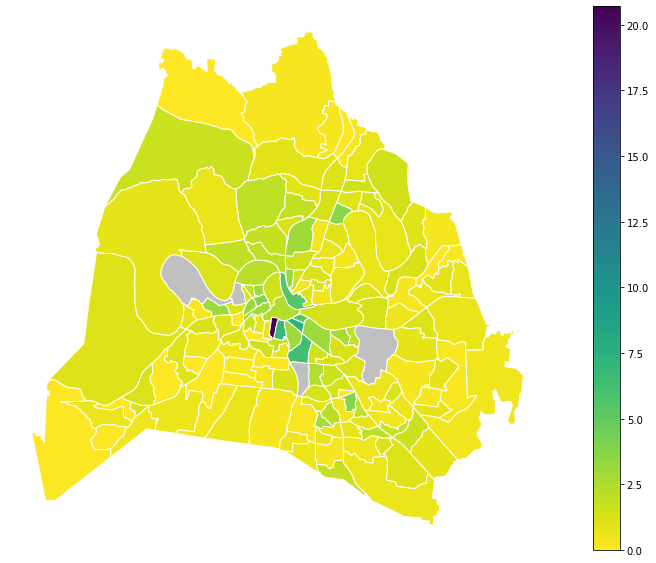

In [95]:
# Create DataFrame for choropleth

choropleth_data = pd.DataFrame(crime_pop_inc.groupby(['tract', 'population', 'median_income'], as_index = False)['incident_number'].nunique())
choropleth_data['incident_rate_per_1000'] = choropleth_data['incident_number'] / choropleth_data['population'] * 1000
choropleth_data = pd.merge(left = tract, right = choropleth_data, how = 'left')
choropleth_data = choropleth_data[['tract', 'population', 'incident_number', 'incident_rate_per_1000', 'geometry', 'median_income']]
choropleth_data = choropleth_data.replace([np.inf, -np.inf, -666666666], np.nan)
choropleth_data['population'] = choropleth_data['population'].fillna(0)

# Plot DataFrame as choropleth

fig, ax = plt.subplots(figsize=(16, 10))

choropleth_data.plot(
    column = 'incident_rate_per_1000',
    cmap = 'viridis_r',
    edgecolor = 'white',
    missing_kwds = {'color': 'silver'},
    legend = 'true',
    ax = ax
)

ax.axis('off');

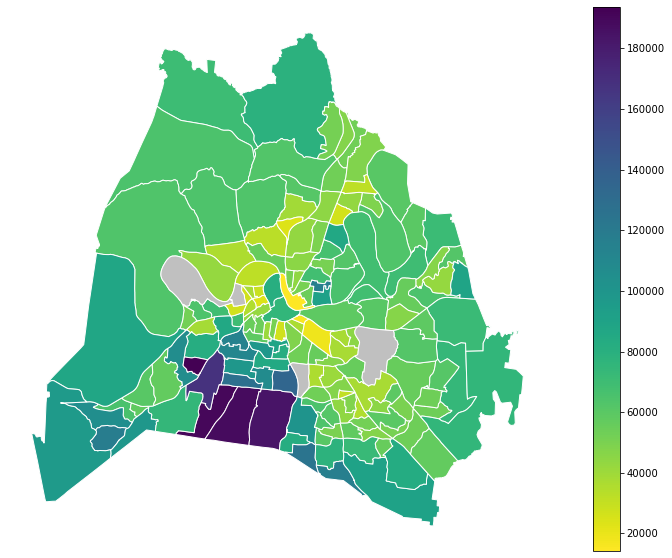

In [85]:
fig, ax = plt.subplots(figsize=(16, 10))

choropleth_data.plot(
    column = 'median_income',
    cmap = 'viridis_r',
    edgecolor = 'white',
    missing_kwds = {'color': 'silver'},
    legend = 'true',
    ax = ax
)

ax.axis('off');

Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. For this, we'll be using the Generalized Linear Models module of the statsmodels library.

In [82]:
# 5(a)  Build a "base model" - a Poisson regression model with just an intercept term with target variable 
#       the rate of burglaries per census tract. (Offset using the [log of the] population so that we are 
#       looking at the rate of burglaries per population instead of the number of burglaries.)

# Create necessary log and intercept columns
  
model_data = choropleth_data.copy()
model_data['intercept'] = 1
model_data['log_population'] = np.log(model_data['population'])
model_data['log_median_income'] = np.log(model_data['median_income'])
model_data = model_data[['tract', 'population', 'incident_number', 'incident_rate_per_1000', 'geometry', 'median_income',
                        'intercept', 'log_population', 'log_median_income']]
model_data = choropleth_data.dropna()

# Generate Untrained Poisson model

untrained_poisson_model = sm.GLM(endog = model_data['incident_number'],
                    exog = model_data['intercept'],
                    offset = model_data['log_population'],
                    family = sm.families.Poisson()).fit()


untrained_poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  157
Model:                            GLM   Df Residuals:                      156
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -605.45
Date:                Mon, 11 Oct 2021   Deviance:                       728.78
Time:                        20:46:50   Pearson chi2:                 1.42e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -6.7251      0.035   -192.813      0.000      -6.793      -6.657
==============================================================================
"""

# 5(b) Now, build a Poisson regression model with target variable the rate of burglaries and predictor variable 
# the median income. Offset by population. Use training and testing datasets to account for equi-dispersion assumption.

# Create training and testing data sets

mask = np.random.rand(len(model_data)) < 0.7
model_train = model_data[mask]
model_test = model_data[~mask]
print('Training data set length='+str(len(model_train)))
print('Testing data set length='+str(len(model_test)))

# Set regression expression defining dependent and regression variables

expr = """incident_rate_per_1000 ~ log_median_income"""

# Set up matrices for training

y_train, X_train = dmatrices(expr, model_train, return_type = 'dataframe')
y_test, X_test = dmatrices(expr, model_test, return_type = 'dataframe')

# Train model and show summary

poisson_training_results = sm.GLM(y_train, X_train, family = sm.families.Poisson()).fit()
poisson_training_results.summary()

# 5(c) Finally, try out a negative binomial model.

# Add the λ vector as a new column to the trained data set 
# Add another column that derives the auxillary Ordinary Least Squares Regression OLSR values 

model_train['BB_LAMBDA'] = poisson_training_results.mu
model_train['AUX_OLS_DEP'] = model_train.apply(lambda x: ((x['incident_rate_per_1000'] - x['BB_LAMBDA']) **2\
                                                          - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)

# Set regression expression where OLS values are the dependent variable and λ vector is the regression variable.

ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

# Configure and fit the OLSR model

aux_olsr_results = smf.ols(ols_expr, model_train).fit()

# Supply the value of alpha found in the OLSR model, train the model, show summary

nb2_training_results = sm.GLM(y_train, X_train, family= sm.families.NegativeBinomial\
                              (alpha = aux_olsr_results.params[0])).fit()
nb2_training_results.summary()

# 5(d) Compare the models by their Akaike information criterion (AIC)

print('Untrained Poisson Model AIC: ' + str(untrained_poisson_model.aic))
print('Trained Poisson Model AIC: ' + str(poisson_training_results.aic))
print('Trained Negative Binomial AIC: ' + str(nb2_training_results.aic))

nb2_predictions = nb2_training_results.get_prediction(X_test)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts = predictions_summary_frame['mean']
actual_counts = y_test['incident_rate_per_1000']

fig = plt.figure(figsize = (10,6))
fig.suptitle('Predicted versus actual incident rates per census tract')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [75]:
# Create training and testing data sets

mask = np.random.rand(len(model_data)) < 0.7
model_train = model_data[mask]
model_test = model_data[~mask]
print('Training data set length='+str(len(model_train)))
print('Testing data set length='+str(len(model_test)))

# Create regression expressions defining both dependent and independent variables

expr_inc = """incident_number ~ log_median_income"""
expr_pop = """incident_number ~ log_population"""

# Set up matrices for training

y_train_inc, X_train_inc = dmatrices(expr_inc, model_train, return_type = 'dataframe')
y_test_inc, X_test_inc = dmatrices(expr_inc, model_test, return_type = 'dataframe')
y_train_pop, X_train_pop = dmatrices(expr_pop, model_train, return_type = 'dataframe')
y_test_pop, X_test_pop = dmatrices(expr_pop, model_test, return_type = 'dataframe')

# Train model and show summary

poisson_training_inc = sm.GLM(y_train_inc, X_train_inc, family = sm.families.Poisson()).fit()
poisson_training_pop = sm.GLM(y_train_pop, X_train_pop, family = sm.families.Poisson()).fit()
display(poisson_training_inc.summary(), poisson_training_pop.summary())

Training data set length=102
Testing data set length=55


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  102
Model:                            GLM   Df Residuals:                      100
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -299.09
Date:                Mon, 11 Oct 2021   Deviance:                       285.26
Time:                        20:39:27   Pearson chi2:                     301.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.6359
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.6139      0.941     12.343      0.000       9.770      13.458
log_median_income    -0.9151      0.087    -10.485      0.000      -1.086      -0.744
=====================================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  102
Model:                            GLM   Df Residuals:                      100
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -339.86
Date:                Mon, 11 Oct 2021   Deviance:                       366.80
Time:                        20:39:27   Pearson chi2:                     404.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1902
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2330      0.855     -2.611      0.009      -3.910      -0.557
log_population     0.4687      0.102      4.584      0.000       0.268       0.669
==================================================================================
"""

In [76]:
# 5(c) Finally, try out a negative binomial model.

# Add the λ vector as a new column to the trained data set 
# Add another column that derives the auxillary Ordinary Least Squares Regression OLSR values 

model_train['BB_LAMBDA_inc'] = poisson_training_inc.mu
model_train['BB_LAMBDA_pop'] = poisson_training_pop.mu
model_train['AUX_OLS_DEP_inc'] = model_train.apply(lambda x: ((x['incident_number'] - x['BB_LAMBDA_inc']) **2\
                                                          - x['BB_LAMBDA_inc']) / x['BB_LAMBDA_inc'], axis=1)
model_train['AUX_OLS_DEP_pop'] = model_train.apply(lambda x: ((x['incident_number'] - x['BB_LAMBDA_pop']) **2\
                                                          - x['BB_LAMBDA_pop']) / x['BB_LAMBDA_pop'], axis=1)

# Set regression expression where OLS values are the dependent variable and λ vector is the regression variable.

ols_expr_inc = """AUX_OLS_DEP_inc ~ BB_LAMBDA_inc - 1"""
ols_expr_pop = """AUX_OLS_DEP_pop ~ BB_LAMBDA_pop - 1"""

# Configure and fit the OLSR model

aux_olsr_results_inc = smf.ols(ols_expr_inc, model_train).fit()
aux_olsr_results_pop = smf.ols(ols_expr_pop, model_train).fit()

# Supply the value of alpha found in the OLSR model, train the model, show summary

nb2_training_inc = sm.GLM(y_train_inc, X_train_inc, family= sm.families.NegativeBinomial\
                              (alpha = aux_olsr_results_inc.params[0])).fit()
nb2_training_pop = sm.GLM(y_train_pop, X_train_pop, family= sm.families.NegativeBinomial\
                              (alpha = aux_olsr_results_pop.params[0])).fit()
display(nb2_training_inc.summary(), nb2_training_pop.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  102
Model:                            GLM   Df Residuals:                      100
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -262.01
Date:                Mon, 11 Oct 2021   Deviance:                       125.10
Time:                        20:39:31   Pearson chi2:                     124.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3134
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.7747      1.707      6.898      0.000       8.429      15.120
log_median_income    -0.9299      0.156     -5.942      0.000      -1.237      -0.623
=====================================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  102
Model:                            GLM   Df Residuals:                      100
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -273.57
Date:                Mon, 11 Oct 2021   Deviance:                       112.43
Time:                        20:39:31   Pearson chi2:                     109.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.05011
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.8684      1.618     -1.155      0.248      -5.040       1.303
log_population     0.4248      0.195      2.180      0.029       0.043       0.807
==================================================================================
"""

In [77]:
print('Untrained Poisson Model AIC: ' + str(untrained_poisson_model.aic))
print('Trained Poisson Model AIC - Median Income Predictor: ' + str(poisson_training_inc.aic))
print('Trained Poisson Model AIC - Population Predictor: ' + str(poisson_training_pop.aic))
print('Trained Negative Binomial AIC - Median Income Predictor: ' + str(nb2_training_inc.aic))
print('Trained Negative Binomial AIC - Population Predictor: ' + str(nb2_training_pop.aic))

Untrained Poisson Model AIC: 1212.9082531097533
Trained Poisson Model AIC - Median Income Predictor: 602.1749404545562
Trained Poisson Model AIC - Population Predictor: 683.7128419038735
Trained Negative Binomial AIC - Median Income Predictor: 528.0263258474548
Trained Negative Binomial AIC - Population Predictor: 551.1358403728544


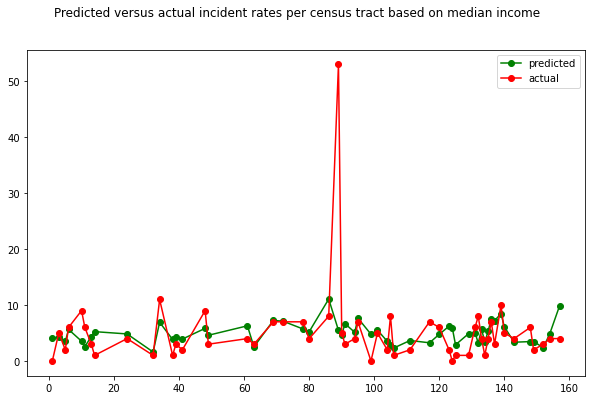

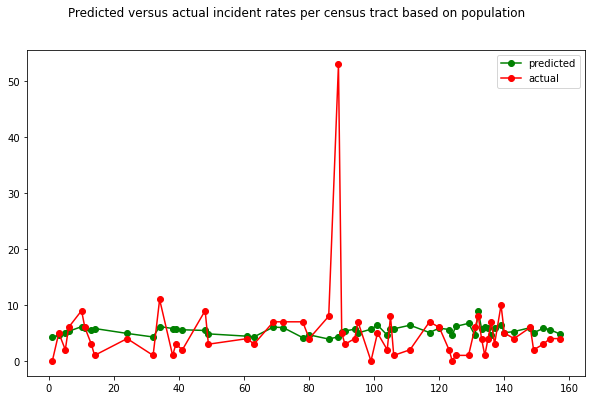

In [78]:
nb2_predictions_inc = nb2_training_inc.get_prediction(X_test_inc)
nb2_predictions_pop = nb2_training_pop.get_prediction(X_test_pop)
predictions_summary_frame_inc = nb2_predictions_inc.summary_frame()
predictions_summary_frame_pop = nb2_predictions_pop.summary_frame()
predicted_counts_inc = predictions_summary_frame_inc['mean']
predicted_counts_pop = predictions_summary_frame_pop['mean']
actual_counts_inc = y_test_inc['incident_number']
actual_counts_pop = y_test_pop['incident_number']


fig_inc = plt.figure(figsize = (10,6))
fig_inc.suptitle('Predicted versus actual incident rates per census tract based on median income')
predicted_inc = plt.plot(X_test_inc.index, predicted_counts_inc, 'go-', label='Predicted counts')
actual_inc = plt.plot(X_test_inc.index, actual_counts_inc, 'ro-', label='Actual counts')
plt.legend(labels = ['predicted', 'actual'])
plt.show()



fig_pop = plt.figure(figsize = (10,6))
fig_pop.suptitle('Predicted versus actual incident rates per census tract based on population')
predicted_pop = plt.plot(X_test_pop.index, predicted_counts_pop, 'go-', label='Predicted counts')
actual_pop = plt.plot(X_test_pop.index, actual_counts_pop, 'ro-', label='Actual counts')
plt.legend(labels = ['predicted', 'actual'])
plt.show()